# Analyzing Big Data II: Project 1

Group members: Yutong Li, Xin Chen

2021/03/08

#### Import Packages

In [3]:
# for preprocessing data:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from dmba import regressionSummary, exhaustive_search
from dmba import adjusted_r2_score, AIC_score, BIC_score
from dmba import backward_elimination, forward_selection, stepwise_selection

## Exercise 1: Classification

**Iris Dataset:** The iris flower dataset is a multivariate data introduced by the British statistician and biologist Ronald Fisher in his 1936 paper. It contains 3 classes of 50 instances each, where each class refers to a type of iris plant. This dataset became a widely-used beginner's test case for many classification problems.

**Goal of this exercise:** In this project, by using the features (sepal_length, sepal_width, petal_length, and petal_width), we are going to use machine learning models including (KNN, Naive Bayes, and Logistic Regression) to classify the type of an iris plant.

For your references, the images for the three species are shown below:

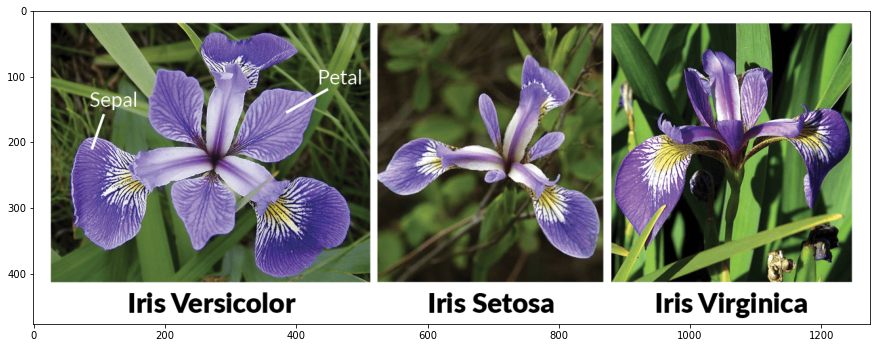

In [4]:
plt.figure(figsize = (15,10))
img = mpimg.imread('iris.png')
imgplot = plt.imshow(img)

plt.show()

(images quoted from http://www.lac.inpe.br/~rafael.santos/Docs/CAP394/WholeStory-Iris.html)

### 1.1 Read and verify data

Since the iris raw dataset has no column names, we added the names manually:

In [5]:
# read data and add column names df
iris = pd.read_csv("iris_dataset.csv", header = None, names = ["sepal_length", "sepal_width", "petal_length", "petal_width", "species"])

In [6]:
iris.shape

(150, 5)

In [7]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


### 1.2 Clean/Prepare data and handle missing data

In [8]:
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


With only three types of species, we change it to a category data type

In [9]:
iris["species"] = iris["species"].astype("category")

In [10]:
# now check the dtype and memory usage again
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   sepal_length  150 non-null    float64 
 1   sepal_width   150 non-null    float64 
 2   petal_length  150 non-null    float64 
 3   petal_width   150 non-null    float64 
 4   species       150 non-null    category
dtypes: category(1), float64(4)
memory usage: 5.1 KB


##### Descriptive statistics for continuous variables:

In [11]:
iris.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
sepal_length,150.0,5.843333,0.828066,4.3,5.1,5.80,6.4,7.9
sepal_width,150.0,3.057333,0.435866,2.0,2.8,3.00,3.3,4.4
petal_length,150.0,3.758000,1.765298,1.0,1.6,4.35,5.1,6.9
petal_width,150.0,1.199333,0.762238,0.1,0.3,1.30,1.8,2.5


We could see that that the four features are not in the same scale from the above descriptive statistics, thus we may need to standardize them in later steps.

In [12]:
iris["species"].value_counts()

Iris-virginica     50
Iris-versicolor    50
Iris-setosa        50
Name: species, dtype: int64

We could see that the dataset has a balanced sampling.

#### Check null values

One big part of data preparation is to make sure we identify and handle the missing data. By using the isnull() function, we will have a dataframe contains False/True values. Then we will check if there is any missing values (any data shows True). 

In [13]:
iris.isnull().values.any()

False

It turns out that the iris dataset does not have any missing value.

### 1.3 Exploratory Data Analysis

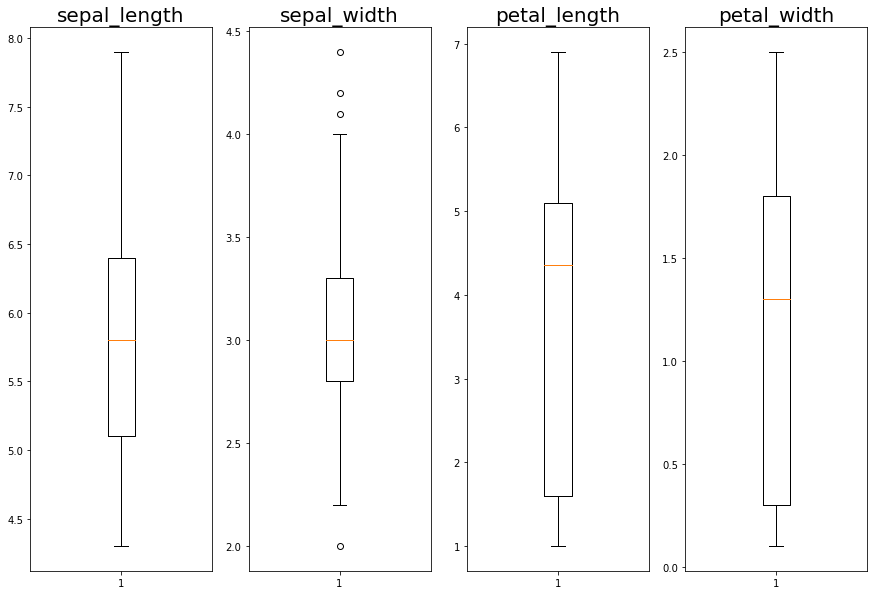

In [14]:
plt.figure(figsize=(15,10))

plt.subplot(1, 4, 1) 
plt.boxplot(iris["sepal_length"]) 
plt.title('sepal_length',fontsize=20) 

plt.subplot(1, 4, 2) 
plt.boxplot(iris["sepal_width"]) 
plt.title('sepal_width',fontsize=20) 

plt.subplot(1, 4, 3) 
plt.boxplot(iris["petal_length"]) 
plt.title('petal_length',fontsize=20)

plt.subplot(1, 4, 4) 
plt.boxplot(iris["petal_width"]) 
plt.title('petal_width',fontsize=20)

plt.show()

<Figure size 720x720 with 0 Axes>

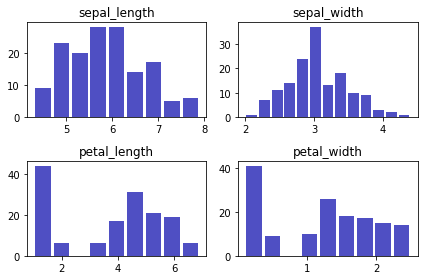

In [15]:
plt.figure(figsize=[10,10])
figure, axis = plt.subplots(2, 2)
axis = axis.ravel()
for idx,ax in enumerate(axis):
    ax.hist(iris.iloc[:,idx], bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
    ax.set_title(iris.columns[idx])
plt.tight_layout()

# quoated from https://www.datacamp.com/community/tutorials/histograms-matplotlib

The boxplots show that there are 4 outlier values in the sepal_width field, but other columns seem to be well distributed.

#### Pairwise relationship between continuous variables

In [16]:
corr_table = iris.corr()
corr_table

,sepal_length,sepal_width,petal_length,petal_width
sepal_length,1.000000,-0.117570,0.871754,0.817941
sepal_width,-0.117570,1.000000,-0.428440,-0.366126
petal_length,0.871754,-0.428440,1.000000,0.962865
petal_width,0.817941,-0.366126,0.962865,1.000000


In [17]:
corr_table.style.background_gradient()

,sepal_length,sepal_width,petal_length,petal_width
sepal_length,1.000000,-0.117570,0.871754,0.817941
sepal_width,-0.117570,1.000000,-0.428440,-0.366126
petal_length,0.871754,-0.428440,1.000000,0.962865
petal_width,0.817941,-0.366126,0.962865,1.000000


From the heatmap, we can see there is strong positive linear relationships between petal_length and petal_width, petal_length and sepal_length, petal_width and sepal_length (all have high Pearson' r values). Hence, in our next steps, we should carefully do a feature selection or feature extraction.

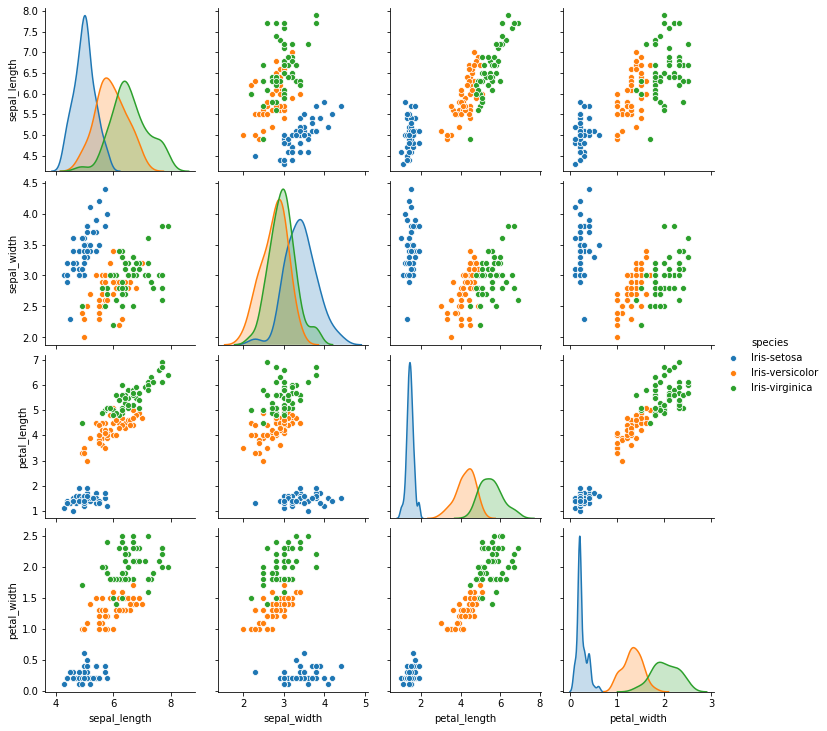

In [18]:
sns.pairplot(iris, hue = "species")

### 1.4 Select features & standardize data if necessary

In [19]:
X = iris.drop("species", axis = 1)
y = iris["species"]

**We plan to use PCA for our further feature extraction. So before we transform the features, we must ensure that the numerical data are normalilzed (all data points need to be centered at the origin, so that linear transformation could be done in subspace)**

In [20]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### 1.5 PCA on standardized data

As we explained earlier, we have large correlations between our features, so PCA is a good way to eliminate correlation and squeeze the dimension to avoid overfitting. 

In [21]:
pca = PCA()
pca.fit(X_scaled)
exp_variance = pca.explained_variance_ratio_

Text(0, 0.5, 'Explained Variance')

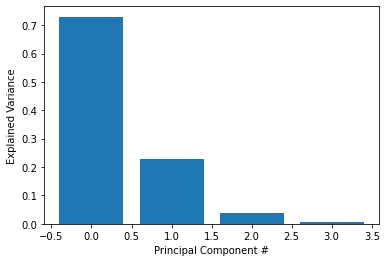

In [22]:
# plot the explained variance using a barplot
plt.bar(range(pca.n_components_), pca.explained_variance_ratio_)
plt.xlabel('Principal Component #')
plt.ylabel("Explained Variance")

In [23]:
pca_Summary_df = pd.DataFrame({"Cumulative proportion" : np.cumsum(pca.explained_variance_ratio_)})
pca_Summary_df = pca_Summary_df.transpose()
pca_Summary_df.columns = ["PC{}".format(i) for i in range(1, len(pca_Summary_df.columns) + 1)]
pca_Summary_df

,PC1,PC2,PC3,PC4
Cumulative proportion,0.729624,0.958132,0.994821,1.0


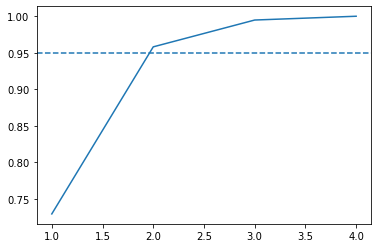

In [24]:
cum_exp_variance = pca.explained_variance_ratio_.cumsum()
plt.plot(range(1, len(pca_Summary_df.columns) + 1), cum_exp_variance)
plt.axhline(y = 0.95, linestyle='--')

From the above results, two PCA components can explain more than 95% variation. Therefore we could just choose n_components = 2.

In [25]:
pca = PCA(n_components = 2, random_state = 10)
pca.fit(X_scaled)
X_transformed = pca.transform(X_scaled)

### 1.6 Conducting machine learning models for classification

Here, we will use the following 3 models:
- KNN
- Naive Bayes
- Logistic Regression

There are many metrics for evaluating a classification model's performance. Since our iris data size is small (150 instances), a cross-validation method could be helpful to generate reliable training and testing data. In this project, we are going to use cross_val_score function from sklean and choose the test accuracy metric for measuing one model's performance.

In [26]:
# create a dictionary to store test_scores
test_score_result = {}

### <i> K Nearest Neighbors (KNN)

KNN model requires tuning hyperparameter k, so we will split our data into a training/validation set, and a testing set. By using cross-validation on the training/validation set, we will again split the training set into a training data for training and validation data to select the best k. After that, the best k is selected, and the model will be trained again on training/validation set, and the final performance will be evaluated on the testing set. (We could use a nested cross-validation as well, but here we only do this once for tuning hyperparameter.)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size = 0.2, random_state = 10, shuffle = True)
accuracy_results = []

neignbors = range(1, 20)

# for each k, get mean accuracy scores and show them as a dataframe
# by using cross-validation on training set, we will split it into train data & validation data
for k in neignbors:
    knn = KNeighborsClassifier(n_neighbors = k)
    res = cross_validate(knn, X_train, y_train, cv = 5, return_train_score = True)
    accuracy_results.append({
        "k": k,
        "train_score": np.mean(res["train_score"]).round(4),
        "validation_score": np.mean(res["test_score"]).round(4)
    })

In [28]:
# find the best k value using validation data
accuracy_df = pd.DataFrame(accuracy_results)
print(accuracy_df)

     k  train_score  validation_score
0    1       1.0000            0.8583
1    2       0.9333            0.8333
2    3       0.9479            0.8833
3    4       0.9521            0.8917
4    5       0.9500            0.9083
5    6       0.9312            0.9167
6    7       0.9333            0.9333
7    8       0.9292            0.9167
8    9       0.9271            0.9167
9   10       0.9312            0.9167
10  11       0.9292            0.9250
11  12       0.9292            0.9167
12  13       0.9271            0.9167
13  14       0.9292            0.9167
14  15       0.9229            0.9083
15  16       0.9167            0.9000
16  17       0.9000            0.9167
17  18       0.9125            0.8917
18  19       0.9146            0.8917


In [29]:
print("The best model is(are) the one(s) below: ")
accuracy_df[accuracy_df.validation_score == accuracy_df.validation_score.max()]

The best model is(are) the one(s) below: 


,k,train_score,validation_score
6,7,0.9333,0.9333


In [30]:
best_k = int(accuracy_df[accuracy_df.validation_score == accuracy_df.validation_score.max()].values[0, 0])
best_k

7

In [31]:
# finally we use our best model, and evaluate on testing set
knn = KNeighborsClassifier(n_neighbors = best_k)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
knn_test = accuracy_score(y_test, y_pred).round(4)
print("Testing set accuracy: ", knn_test)

Testing set accuracy:  0.9


In [32]:
test_score_result["KNN"] = knn_test

### <i> Naive Bayes

Here, we are going to use the Gaussian Naive Bayes method for classification. Gaussian Naive Bayes assumes the features all follow the normal distribution, and it deals more with features that are continuous. Therefore, Gaussian Naive Bayes is more appropriate than Multinomial Naive Bayes that deals with discrete counts.

In [33]:
naive_bayes = GaussianNB()
scores = cross_val_score(naive_bayes, X_transformed, y, cv = 5)
print("Cross-validation scores: {}".format(scores.round(4)))
print("Average cross-validation score: {:.3f}".format(scores.mean().round(4)))

Cross-validation scores: [0.8667 0.9333 0.8667 0.8667 0.9333]
Average cross-validation score: 0.893


In [34]:
test_score_result["Naive Bayes"] = scores.mean().round(4)

### <i> Logistic Regression

For Logistic Regression, the "multinomial" method might be a best choice for multi-class problems. "Ovr" is another option, but Multinomial is preferred than Ovr here because our classes are multually exclusive. Here is our reference that discusses about the difference between these two methods: https://stats.stackexchange.com/questions/52104/multinomial-logistic-regression-vs-one-vs-rest-binary-logistic-regression

In [35]:
log_reg = LogisticRegression(penalty = "none", solver = "lbfgs", max_iter = 1000, multi_class = "multinomial")
scores = cross_val_score(log_reg, X_transformed, y, cv = 5)
print("Cross-validation scores: {}".format(scores.round(4)))
print("Average cross-validation score: {:.3f}".format(scores.mean().round(4)))

Cross-validation scores: [0.8667 0.9667 0.8333 0.9    0.9667]
Average cross-validation score: 0.907


In [36]:
test_score_result["Logistic"] = scores.mean().round(4)

### 1.7 Compare models' performances

Now, with all test score results stored in the dictionary, we could compare the model's performances based on the our results.

In [37]:
test_score_result

{'KNN': 0.9, 'Naive Bayes': 0.8933, 'Logistic': 0.9067}

#### Change the dictionary to a dataframe

In [38]:
test_score_result_df= pd.DataFrame.from_dict(test_score_result, orient = "index", columns = ["test_score"])
test_score_result_df

,test_score
KNN,0.9000
Naive Bayes,0.8933
Logistic,0.9067


#### Rank models from best to worst

In [39]:
# sort by "test_score" in desc. oder
test_score_result_df.sort_values("test_score", ascending = False)

,test_score
Logistic,0.9067
KNN,0.9000
Naive Bayes,0.8933


### 1.8 Conclusion and reflections

- **Compare the test accuracy scores**

From the above result, Logistic model generate the best test accuracy score and reach an accuracy of 90.67%. This implies that, if we are given new data containing a flower's sepal_length, sepal_width, petal_length, and petal_width, by using Logistic model, we could classify the species of this flower and attain an accuracy 90.67% of the time. Based on the results, KNN model and Naive Bayes methods also perform pretty well, very closed to the accuracy for Logistic model. 

- **About cross validation**

In the above steps, we chose to use cross-validation method for all models. We think using one train-test split might be enough based on our EDA (1.3) when there are only 4 sepal_width values that are outliers. However, it is always safer to use cross-validation, split the data differently, and calculate an average test score for different combination of train-test splits.

- **Reflection on PCA**

Due to the high correlations between each field, we carefully made decisions on feature selection and feature extraction. We think sepal_length, sepal_width, petal_length, and petal_width are four necessary properties/attirbutes for each flower. So it might be more advisable in this case to produce new components that are linear combination of these four feasures that accounts for most of the variation than to eliminate 1 or 2 necessary features absolutely. As a result, we decided to use PCA method to reduce our data dimension and still maintain most of the variation in the dataset. Hence, based on the scree plot and cumulative explained variation, we decided to select n_component = 2 to ensure a 95% variation. It is important to mention that the numerical features data must be normalized first before we do PCA transforamtion. So the test accuracy might be a little different before and after we normalize the features. 

- **Performance measurement**

For simplicity, the cross_val_score method provides us with a default accuracy score, so we selected this most commonly-used metric -- accuracy. However, for classification problems, there are a lot of other metrics that could be used for measuring a model's performance, i.e. ROC/AOC,  Gain chart, lift chart, and confusion matrix's recall (sensitivity), specificity, precision scores. 

One more thing to mention is that, if we think about a naive benchmark for this problem, when we assign randomly one class to all of our predictions, we could still get an accuracy of 0.333. This naive benchmark could always be used as a baseline for us to check our other models' performance. 

- **Insights pertaining to the data**

This data set contains only 150 instances. A small training set might be prone to an underfitting problem, and it may also make our test data not enough. However, the possible values of a flower's sepal_length, sepal_width, petal_length, and petal_width are also limited, so 150 instances may already include a lot of information. We are also wondering if there are other features that could be used to determine a flower's species that accounts for the rest of misclassification problem.

## Exercise 2: Regression

**About our data:** Bike-sharing rental process is highly correlated to the environmental and seasonal settings. For instance, weather conditions, precipitation, day of week, season, hour of the day, etc. can affect the rental behaviors. The core data set is related to the two-year historical log corresponding to years 2011 and 2012 from Capital Bikeshare system, Washington D.C., USA. We aggregated the data on two hourly and daily basis and then extracted and added the corresponding weather and seasonal information.https://www.kaggle.com/marklvl/explanatory-data-analysis-on-bike-sharing-dataset/data

**Business context:** 
Bike sharing systems are new generation of traditional bike rentals where whole process from membership, rental and return back has become automatic. Through these systems, user is able to easily rent a bike from a particular position and return back at another position. Currently, there are about over 500 bike-sharing programs around the world which is composed of over 500 thousands bicycles. Today, there exists great interest in these systems due to their important role in traffic, environmental and health issues.(Project_1.pdf)

Apart from interesting real world applications of bike sharing systems, the characteristics of data being generated by
these systems make them attractive for the research. Opposed to other transport services such as bus or subway, the duration
of travel, departure and arrival position is explicitly recorded in these systems. This feature turns bike sharing system into
a virtual sensor network that can be used for sensing mobility in the city. Hence, it is expected that most of important
events in the city could be detected via monitoring these data.https://www.kaggle.com/marklvl/explanatory-data-analysis-on-bike-sharing-dataset/data

**Goal of this exercise:** Using the prescriptive method of conducting regression problems, create one Python notebook that predicts the count of casual users (feature casual), count of registered users (feature registered), and the total count of both casual and registered users (feature cnt). Use the multi-regression model and comment your notebook.

## 1. day.csv dataset

day.csv dataset: There are 731 instances and 16 columns.

### 1.1 Read and verify data

In [40]:
bike_df = pd.read_csv('day.csv', parse_dates = ["dteday"])

In [41]:
bike_df.shape

(731, 16)

In [42]:
bike_df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


### 1.2 Clean/Prepare data and handle missing data

In [43]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     731 non-null    int64         
 1   dteday      731 non-null    datetime64[ns]
 2   season      731 non-null    int64         
 3   yr          731 non-null    int64         
 4   mnth        731 non-null    int64         
 5   holiday     731 non-null    int64         
 6   weekday     731 non-null    int64         
 7   workingday  731 non-null    int64         
 8   weathersit  731 non-null    int64         
 9   temp        731 non-null    float64       
 10  atemp       731 non-null    float64       
 11  hum         731 non-null    float64       
 12  windspeed   731 non-null    float64       
 13  casual      731 non-null    int64         
 14  registered  731 non-null    int64         
 15  cnt         731 non-null    int64         
dtypes: datetime64[ns](1), floa

In [44]:
bike_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
instant,731.0,366.000000,211.165812,1.000000,183.500000,366.000000,548.500000,731.000000
season,731.0,2.496580,1.110807,1.000000,2.000000,3.000000,3.000000,4.000000
yr,731.0,0.500684,0.500342,0.000000,0.000000,1.000000,1.000000,1.000000
mnth,731.0,6.519836,3.451913,1.000000,4.000000,7.000000,10.000000,12.000000
holiday,731.0,0.028728,0.167155,0.000000,0.000000,0.000000,0.000000,1.000000
weekday,731.0,2.997264,2.004787,0.000000,1.000000,3.000000,5.000000,6.000000
workingday,731.0,0.683995,0.465233,0.000000,0.000000,1.000000,1.000000,1.000000
weathersit,731.0,1.395349,0.544894,1.000000,1.000000,1.000000,2.000000,3.000000
temp,731.0,0.495385,0.183051,0.059130,0.337083,0.498333,0.655417,0.861667
atemp,731.0,0.474354,0.162961,0.079070,0.337842,0.486733,0.608602,0.840896


In [45]:
bike_df.isnull().values.any()

False

### 1.3 Exploratory Data Analysis

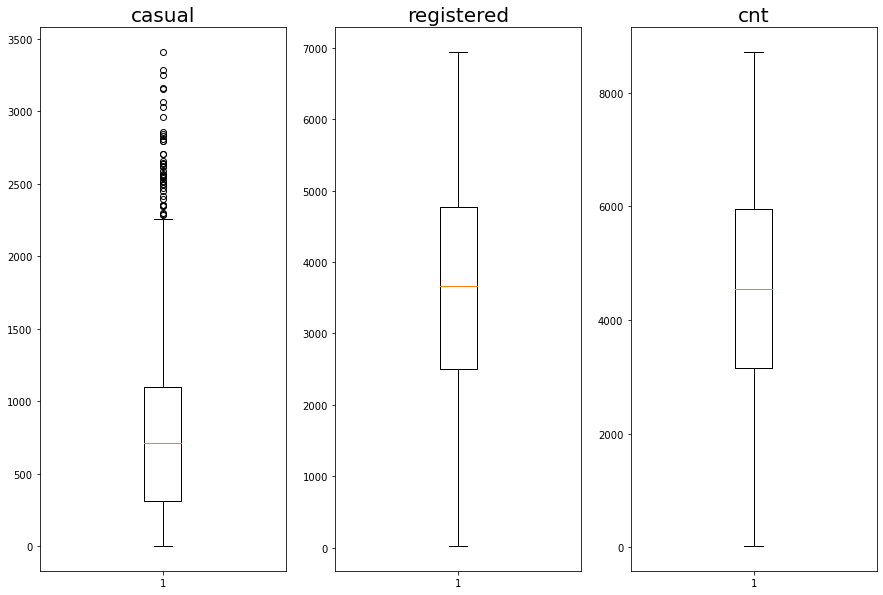

In [46]:
plt.figure(figsize=(15,10))

plt.subplot(1, 3, 1) 
plt.boxplot(bike_df["casual"]) 
plt.title('casual',fontsize=20) 

plt.subplot(1, 3, 2) 
plt.boxplot(bike_df["registered"]) 
plt.title('registered',fontsize=20) 

plt.subplot(1, 3, 3) 
plt.boxplot(bike_df["cnt"]) 
plt.title('cnt',fontsize=20)

plt.show()

It seems that the casual column contains many outliers, so we could use a histogram to see its distribution: 

Text(0.5, 1.0, 'casual')

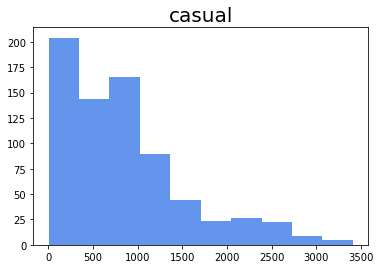

In [47]:
plt.hist(bike_df["casual"], color = "cornflowerblue") 
plt.title('casual',fontsize=20) 

From this histogram, the casual counts are skewed to the right, which means that there are a few extreme large counts, but most value for casual are small and below 1460 (approx. 75%).

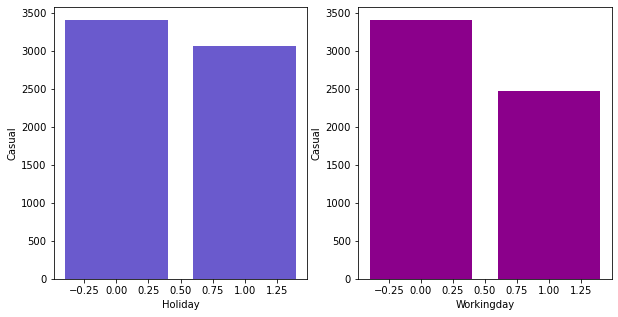

In [48]:
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.bar(data=bike_df, x = 'holiday', height = 'casual', color = "slateblue")
plt.xlabel("Holiday")
plt.ylabel("Casual")

plt.subplot(1, 2, 2)
plt.bar(data=bike_df, x = 'workingday', height = 'casual', color = "darkmagenta")
plt.xlabel("Workingday")
plt.ylabel("Casual")
plt.show()

We could see that holiday and workingday do affect the total counts of bike rental. If there is a holiday, less people tend to be casual. Workingday seems to be of same importance as the holiday factor in determining the number of casual users, i.e. less casual users when it is a workingday.

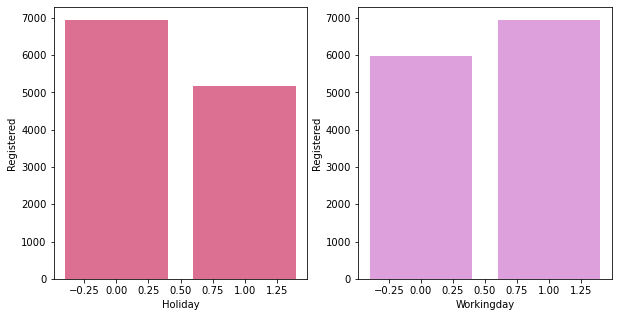

In [49]:
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.bar(data=bike_df, x = 'holiday', height = 'registered', color = "palevioletred")
plt.xlabel("Holiday")
plt.ylabel("Registered")

plt.subplot(1, 2, 2)
plt.bar(data=bike_df, x = 'workingday', height = 'registered', color = "plum")
plt.xlabel("Workingday")
plt.ylabel("Registered")
plt.show()

From the above bar charts, for registered users, holiday leads to less people in registering. And unlike our earlier analysis, workingday factor affects the counts positively, i.e. more people register on working days.

#### Pairwise relationship between continuous variables

In [50]:
bike_df.corr().style.background_gradient()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,1.000000,0.412224,0.866025,0.496702,0.016145,-0.000016,-0.004337,-0.021477,0.150580,0.152638,0.016375,-0.112620,0.275255,0.659623,0.628830
season,0.412224,1.000000,-0.001844,0.831440,-0.010537,-0.003080,0.012485,0.019211,0.334315,0.342876,0.205445,-0.229046,0.210399,0.411623,0.406100
yr,0.866025,-0.001844,1.000000,-0.001792,0.007954,-0.005461,-0.002013,-0.048727,0.047604,0.046106,-0.110651,-0.011817,0.248546,0.594248,0.566710
mnth,0.496702,0.831440,-0.001792,1.000000,0.019191,0.009509,-0.005901,0.043528,0.220205,0.227459,0.222204,-0.207502,0.123006,0.293488,0.279977
holiday,0.016145,-0.010537,0.007954,0.019191,1.000000,-0.101960,-0.253023,-0.034627,-0.028556,-0.032507,-0.015937,0.006292,0.054274,-0.108745,-0.068348
weekday,-0.000016,-0.003080,-0.005461,0.009509,-0.101960,1.000000,0.035790,0.031087,-0.000170,-0.007537,-0.052232,0.014282,0.059923,0.057367,0.067443
workingday,-0.004337,0.012485,-0.002013,-0.005901,-0.253023,0.035790,1.000000,0.061200,0.052660,0.052182,0.024327,-0.018796,-0.518044,0.303907,0.061156
weathersit,-0.021477,0.019211,-0.048727,0.043528,-0.034627,0.031087,0.061200,1.000000,-0.120602,-0.121583,0.591045,0.039511,-0.247353,-0.260388,-0.297391
temp,0.150580,0.334315,0.047604,0.220205,-0.028556,-0.000170,0.052660,-0.120602,1.000000,0.991702,0.126963,-0.157944,0.543285,0.540012,0.627494
atemp,0.152638,0.342876,0.046106,0.227459,-0.032507,-0.007537,0.052182,-0.121583,0.991702,1.000000,0.139988,-0.183643,0.543864,0.544192,0.631066


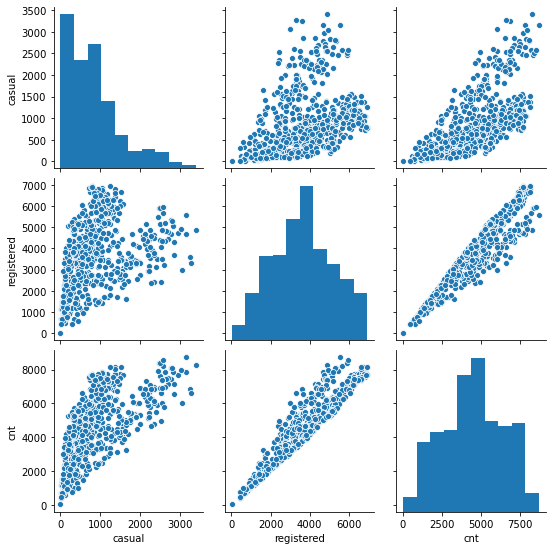

In [51]:
sns.pairplot(bike_df[["casual", "registered", "cnt"]])

From the above scatter matrix, there is a strong positive linear relationship between registered and cnt. And it seems that casual is also positively correlated with register and cnt. 

## 1.4 Prediction on "Casual" User

### 1.4.1 Select all possible features & standardize data if necessary

- **Comment for possible predictors choosing:**
Bellow we choose 'season','mnth','holiday','weekday','workingday','weathersit', 'temp','atemp','hum', and'windspeed' for prediction on numbers of casual users.
To predict the numbers for casual users, we pick two types of factors that are likely to impact their probability to use the services.
The 1st kind of factors are weather related variables. These include season, mnth, weathersit, temp, atemp, hum and windspeed. We assume that a casual user is more willing to use sharing bike when the season/month is warmer, the weather condition is fine, both temperature and feeling temperature are not too cold and too warm, the air is not too humid or too dry, and windspeed are not strong.
The 2nd kind of factors are time related variables. These include holiday, weekday, and workingday. Again, we assume that a casual user is more likely to use sharing bike when it's on holidays/weekends or/and when it's not a workingday.

In [52]:
predictors = ['season','mnth','holiday','weekday','workingday','weathersit', 'temp','atemp','hum','windspeed']
outcome = 'casual'

In [53]:
X = bike_df[predictors]
y = bike_df[outcome]

- Since we are going to use Linear Regression for our prediction, it does not affect our estimation coefficients at all even if we don't standardize our data.

### 1.4.2 Linear Regression with <i>all features
First, we are going to do regression using all of our possible features and see how our model performs:

In [54]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=9)

#### (1) Train our model:

In [55]:
bike_lm = LinearRegression()
bike_lm.fit(X_train, y_train)

LinearRegression()

In [56]:
print('intercept ', bike_lm.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': bike_lm.coef_}))

intercept  932.1215956345538
    Predictor  coefficient
0      season    61.341586
1        mnth   -11.495530
2     holiday  -233.140102
3     weekday    22.147281
4  workingday  -750.767603
5  weathersit  -107.703035
6        temp  1596.674861
7       atemp   407.743832
8         hum  -634.747865
9   windspeed  -910.038663


#### (2) Performance on training data:
The result below will show how well the data fits our model.

In [57]:
# print training set performance
regressionSummary(y_train, bike_lm.predict(X_train))


Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 390.9546
            Mean Absolute Error (MAE) : 271.0007
          Mean Percentage Error (MPE) : -9.7459
Mean Absolute Percentage Error (MAPE) : 79.1768


#### (3) Performance on testing data:

In [58]:
# Use predict() to make predictions on a new set
bike_lm_pred = bike_lm.predict(X_test)

In [59]:
result = pd.DataFrame({'Predicted': bike_lm_pred, 'Actual': y_test,
                       'Residual': y_test - bike_lm_pred})
result.head(10)

,Predicted,Actual,Residual
730,-160.251743,439,599.251743
99,970.804489,1188,217.195511
311,536.023445,376,-160.023445
603,1349.789790,1483,133.210210
503,918.407071,1521,602.592929
89,-212.480422,179,391.480422
132,450.178011,692,241.821989
478,-61.657608,195,256.657608
124,590.022741,614,23.977259
589,1850.132904,2182,331.867096


In [60]:
# Compute common accuracy measures
regressionSummary(y_test, bike_lm_pred)


Regression statistics

                      Mean Error (ME) : 73.6018
       Root Mean Squared Error (RMSE) : 441.0611
            Mean Absolute Error (MAE) : 304.4271
          Mean Percentage Error (MPE) : -3.3778
Mean Absolute Percentage Error (MAPE) : 66.6580


#### (4) Check residuals:

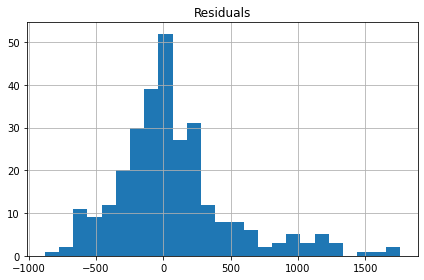

In [61]:
bike_lm_pred = bike_lm.predict(X_test)
all_residuals = y_test - bike_lm_pred


ax = pd.DataFrame({'Residuals': all_residuals}).hist(bins=25)
plt.tight_layout()
plt.show()

We can see from the plot that the residuals are skewed to the right.

### 1.4.3 Feature selection

From the above test results, we could consider a feature selection process in order to keep the best set of regressors.

#### (1) Backward elimination

In [62]:
def train_model(variables):
    model = LinearRegression()
    model.fit(X_train[variables], y_train)
    return model

def score_model(model, variables):
    return AIC_score(y_train, model.predict(X_train[variables]), model)

best_model, best_variables = backward_elimination(X_train.columns, train_model, score_model, verbose=True)
print(best_variables)

Variables: season, mnth, holiday, weekday, workingday, weathersit, temp, atemp, hum, windspeed
Start: score=6495.48
Step: score=6493.76, remove atemp
Step: score=6493.29, remove mnth
Step: score=6493.29, remove None
['season', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'hum', 'windspeed']


#### (2) Forward selection

In [63]:
# The initial model is the constant model - this requires special handling in train_model and score_model
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(X_train[variables], y_train)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(y_train, [y_train.mean()] * len(y_train), model, df=1)
    return AIC_score(y_train, model.predict(X_train[variables]), model)

best_model, best_variables = forward_selection(X_train.columns, train_model, score_model, verbose=True)
print(best_variables)

Variables: season, mnth, holiday, weekday, workingday, weathersit, temp, atemp, hum, windspeed
Start: score=6921.51, constant
Step: score=6765.12, add temp
Step: score=6550.03, add workingday
Step: score=6516.57, add weathersit
Step: score=6511.09, add windspeed
Step: score=6500.39, add hum
Step: score=6496.64, add weekday
Step: score=6494.59, add holiday
Step: score=6493.29, add season
Step: score=6493.29, add None
['temp', 'workingday', 'weathersit', 'windspeed', 'hum', 'weekday', 'holiday', 'season']


### <i>1.4.4 Prediction formula on casual user count
After using forward selection and backward elimination, we decide that 'temp', 'workingday', 'weathersit', 'windspeed', 'hum', 'weekday', 'holiday', and 'season' are the best predictors for prediction on casual user count.

In [64]:
predictors_casual = ['temp', 'workingday', 'weathersit', 'windspeed', 'hum', 'weekday', 'holiday', 'season']
outcome = 'casual'

X = bike_df[predictors_casual]
y = bike_df[outcome]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=9)

In [65]:
bike_lm_casual = LinearRegression()
bike_lm_casual.fit(X_train, y_train)

LinearRegression()

In [66]:
# print coefficients
print('intercept ', bike_lm_casual.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': bike_lm_casual.coef_}))

intercept  950.8368652041733
    Predictor  coefficient
0        temp  1973.289407
1  workingday  -751.827799
2  weathersit  -106.494301
3   windspeed  -918.655819
4         hum  -656.808692
5     weekday    21.765827
6     holiday  -239.441206
7      season    32.605248


In [67]:
print('prediction formula on casual user count: ')
print('')
print('casual user count =', round(bike_lm_casual.intercept_,4), '+', round(bike_lm_casual.coef_[0], 4), '*', str(X.columns[0]), '+(', round(bike_lm_casual.coef_[1], 4),'*',str(X.columns[1]),')\n+(',
      round(bike_lm_casual.coef_[2], 4), '*',str(X.columns[2]),')+(',round(bike_lm_casual.coef_[3], 4),'*',str(X.columns[3]),')+(', round(bike_lm_casual.coef_[4], 4),'*',str(X.columns[4]),')\n+(', round(bike_lm_casual.coef_[5], 4),
      '*',str(X.columns[5]),')+(', round(bike_lm_casual.coef_[6], 4),'*',str(X.columns[6]),')+(', round(bike_lm.coef_[7], 4),'*', str(X.columns[7]),')')

prediction formula on casual user count: 

casual user count = 950.8369 + 1973.2894 * temp +( -751.8278 * workingday )
+( -106.4943 * weathersit )+( -918.6558 * windspeed )+( -656.8087 * hum )
+( 21.7658 * weekday )+( -239.4412 * holiday )+( 407.7438 * season )


#### Performance on testing data:

In [68]:
# Use predict() to make predictions on a new set
bike_lm_pred = bike_lm_casual.predict(X_test)

In [69]:
regressionSummary(y_test, bike_lm_pred)


Regression statistics

                      Mean Error (ME) : 75.5486
       Root Mean Squared Error (RMSE) : 442.7615
            Mean Absolute Error (MAE) : 305.8307
          Mean Percentage Error (MPE) : 0.1604
Mean Absolute Percentage Error (MAPE) : 68.1030


We see the mean error of our model on testing data is 75.5486, which is slightly higher than previous mean scores on all features. The reason might be that our feature selection is conducting using AIC metric. 

## 1.5 Prediction on "Registered" User

### 1.5.1 Select all possible features & standardize data if necessary

**Comment for possible predictors choosing:** 
- Below we choose 'yr','workingday','temp','atemp' for prediction on numbers of registered users. 
- Choosing 'yr' is because we see some correlation between 'registerd' and 'yr'.
- Choosing 'workingday' is because we assume that during workingdays, registered users will more likely to use the bike as transpotation.
- Choosing 'temp' and 'atemp' is because we think temperature matthers to the numbers of registered users.

In [70]:
predictors = ['yr','workingday','temp','atemp']
outcome = 'registered'

In [71]:
X = bike_df[predictors]
y = bike_df[outcome]

### 1.5.2 Linear Regression with <i>all features
First, we are going to do regression using all of our possible features and see how our model performs:

In [72]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=9)

#### (1) Train our model:

In [73]:
bike_lm = LinearRegression()
bike_lm.fit(X_train, y_train)

LinearRegression()

In [74]:
print('intercept ', bike_lm.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': bike_lm.coef_}))

intercept  -117.31856454297758
    Predictor  coefficient
0          yr  1768.228626
1  workingday   979.573145
2        temp  1376.129095
3       atemp  3162.339287


#### (2) Performance on training data:
The result below will show how well the data fits our model.

In [75]:
# print training set performance
regressionSummary(y_train, bike_lm.predict(X_train))


Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 898.1784
            Mean Absolute Error (MAE) : 699.9027
          Mean Percentage Error (MPE) : -64.2520
Mean Absolute Percentage Error (MAPE) : 80.9084


#### (3) Performance on testing data:

In [76]:
# Use predict() to make predictions on a new set
bike_lm_pred = bike_lm.predict(X_test)

In [77]:
result = pd.DataFrame({'Predicted': bike_lm_pred, 'Actual': y_test,
                       'Residual': y_test - bike_lm_pred})
result.head(10)

,Predicted,Actual,Residual
730,3634.238998,2290,-1344.238998
99,1819.317488,1707,-112.317488
311,2727.835223,3829,1101.164777
603,4434.722177,3772,-662.722177
503,5149.681419,6118,968.318581
89,2046.054970,1506,-540.054970
132,3130.665050,3413,282.334950
478,4025.397942,3019,-1006.397942
124,2891.619139,3819,927.380861
589,4653.724239,4362,-291.724239


In [78]:
# Compute common accuracy measures
regressionSummary(y_test, bike_lm_pred)


Regression statistics

                      Mean Error (ME) : 90.7209
       Root Mean Squared Error (RMSE) : 796.2328
            Mean Absolute Error (MAE) : 638.4164
          Mean Percentage Error (MPE) : -5.9001
Mean Absolute Percentage Error (MAPE) : 23.6891


#### (4) Check residuals:

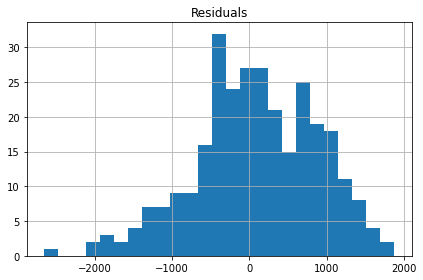

In [79]:
bike_lm_pred = bike_lm.predict(X_test)
all_residuals = y_test - bike_lm_pred

ax = pd.DataFrame({'Residuals': all_residuals}).hist(bins=25)
plt.tight_layout()
plt.show()

We can see from the plot that the residuals are skewed a little bit to the left.

### 1.5.3 Feature selection

From the above test results, we could consider a feature selection process in order to keep the best set of regressors.

#### (1) Backward elimination

In [80]:
def train_model(variables):
    model = LinearRegression()
    model.fit(X_train[variables], y_train)
    return model

def score_model(model, variables):
    return AIC_score(y_train, model.predict(X_train[variables]), model)

best_model, best_variables = backward_elimination(X_train.columns, train_model, score_model, verbose=True)
print(best_variables)

Variables: yr, workingday, temp, atemp
Start: score=7212.11
Step: score=7210.90, remove temp
Step: score=7210.90, remove None
['yr', 'workingday', 'atemp']


#### (2) Forward selection

In [81]:
# The initial model is the constant model - this requires special handling in train_model and score_model
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(X_train[variables], y_train)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(y_train, [y_train.mean()] * len(y_train), model, df=1)
    return AIC_score(y_train, model.predict(X_train[variables]), model)

best_model, best_variables = forward_selection(X_train.columns, train_model, score_model, verbose=True)
print(best_variables)

Variables: yr, workingday, temp, atemp
Start: score=7692.80, constant
Step: score=7518.68, add yr
Step: score=7306.30, add atemp
Step: score=7210.90, add workingday
Step: score=7210.90, add None
['yr', 'atemp', 'workingday']


### 1.5.4 Prediction formula on registered user count
After using forward selection and backward elimination, we decide that 'temp', 'workingday', 'weathersit', 'windspeed', 'hum', 'weekday', 'holiday', and 'season' are the best predictors for prediction on casual user count.

In [82]:
predictors_regist = ['yr', 'atemp', 'workingday']
outcome = 'registered'

X = bike_df[predictors_regist]
y = bike_df[outcome]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=9)

In [83]:
bike_lm_regist = LinearRegression()
bike_lm_regist.fit(X_train, y_train)

LinearRegression()

In [84]:
# print coefficients
print('intercept ', bike_lm_regist.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': bike_lm_regist.coef_}))

intercept  -158.80784554693673
    Predictor  coefficient
0          yr  1771.935997
1       atemp  4682.332714
2  workingday   980.341145


In [85]:
print('prediction formula on registered user count')
print('')
print('registered user count =', round(bike_lm_regist.intercept_, 4), '+', round(bike_lm_regist.coef_[0], 4),'*',str(X.columns[0]),'+(', round(bike_lm_regist.coef_[1], 4),'*',str(X.columns[1]),')+(', round(bike_lm_regist.coef_[2], 4),'*',str(X.columns[2]),')')

prediction formula on registered user count

registered user count = -158.8078 + 1771.936 * yr +( 4682.3327 * atemp )+( 980.3411 * workingday )


#### Performance on testing data:

In [86]:
# Use predict() to make predictions on a new set
bike_lm_pred = bike_lm_regist.predict(X_test)

In [87]:
regressionSummary(y_test, bike_lm_pred)


Regression statistics

                      Mean Error (ME) : 90.2374
       Root Mean Squared Error (RMSE) : 792.0792
            Mean Absolute Error (MAE) : 635.3961
          Mean Percentage Error (MPE) : -5.9112
Mean Absolute Percentage Error (MAPE) : 23.6109


## 1.6 Prediction on total count in year 2013

In [88]:
# we choose mean values on 2011 and 2012 to predict daily data in 2013
mean_casual = bike_df[predictors_casual].mean().values.reshape(1, 8)
casual_user_count = bike_lm_casual.predict(mean_casual)

In [89]:
mean_regist = bike_df[predictors_regist].mean().values.reshape(1, 3)

In [90]:
# we use yr=2 for 2013
mean_regist[0, 0] = 2

In [91]:
registered_user_count = bike_lm_regist.predict(mean_regist)

In [92]:
# summing up casual and registered user count
total_user_count = casual_user_count + registered_user_count

In [93]:
# print out each prediction
print('2013 Daily casual user count:',casual_user_count[0].round())
print('2013 Daily registered user count:', registered_user_count[0].round())
print('2013 Daily total user count:', total_user_count[0].round())

2013 Daily casual user count: 818.0
2013 Daily registered user count: 6277.0
2013 Daily total user count: 7095.0


### 1.6.1 Comparison of daily total user count in 2011, 2012 and 2013

In [94]:
print('2011 daily total user count:',round(np.mean(bike_df[bike_df["yr"] == 0]['cnt']),0))
print('2012 daily total user count:',round(np.mean(bike_df[bike_df["yr"] == 1]['cnt']),0))
print('2013 daily total user count:', total_user_count.round()[0])

2011 daily total user count: 3406.0
2012 daily total user count: 5600.0
2013 daily total user count: 7095.0


### 1.6.2 Comparison of daily casual user count in 2011, 2012 and 2013

In [95]:
print('2011 daily casual user count:',round(np.mean(bike_df[bike_df["yr"] == 0]['casual']),0))
print('2012 daily casual user count:',round(np.mean(bike_df[bike_df["yr"] == 1]['casual']),0))
print('2013 daily casual user count:', casual_user_count.round()[0])

2011 daily casual user count: 677.0
2012 daily casual user count: 1018.0
2013 daily casual user count: 818.0


### 1.6.3 Comparison of daily registered user count in 2011, 2012 and 2013

In [96]:
print('2011 daily registered user count:',round(np.mean(bike_df[bike_df["yr"] == 0]['registered']),0))
print('2012 daily registered user count:',round(np.mean(bike_df[bike_df["yr"] == 1]['registered']),0))
print('2013 daily registered user count:', registered_user_count.round()[0])

2011 daily registered user count: 2728.0
2012 daily registered user count: 4581.0
2013 daily registered user count: 6277.0


## 1.7 Prediction Results Interpretation

In section 1.6 above, we predict both casual and registered users in 2013. And we also calculation the daily total user count by summing up casual and registered user count. The daily total user count is about 7095.0, which is higher than 3406.0 counts in year 2011 and 5600.0 counts in year 2012. Also, combined with the fact that the users were increasing from 2011 to 2012, we suggest that the bike sharing company should purchase more bike to fit the increasing demand.

We also see a decrease on daily casual user count on 2013 based on our prediction. And in section 1.6.3, we see a increase on daily registered user count in 2013. The reason for these might be explained by several reasons:

1. Some casual user become registered user. Thus, some portion of the increase of daily registered user count may come from the casual user. This might be a good sign for the company. 

2. If the increase of registered users were not highly related to the decrease of casual users, then it might indicate that sharing bike has an increasing value on working transportation, instead of recreation purposes. Based on these, we suggust company could spend more funding on advertisement targeting working group, thus attracting more potantial customers.

## 1.8 Conclusion and Reflection

1. Domain-specific reasoning: It's a good sign to see increase in registered users from 2011 to 2013. However, to really understand the increase, we will need to analyze extra data on the registered users.
2. Modeling process-specific reasoning: In this project, we use linear regression instead of using nonlinear model. Maybe a nonlinear model will fit better on the dataset.

===================================================================================================================

# Extra Part Using hour.csv Dataset

Following the exactly same procedures, we also predicted on the hourly dataset, and make predictions for 2013.

## 2. hour.csv dataset

hour.csv dataset: This dataset has 17379 instances and 17 columns.

### 2.1 Read and verify data

In [97]:
bike_df = pd.read_csv('hour.csv', parse_dates = ["dteday"])

In [98]:
bike_df.shape

(17379, 17)

In [99]:
bike_df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


### 2.2 Clean/Prepare data and handle missing data

In [100]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     17379 non-null  int64         
 1   dteday      17379 non-null  datetime64[ns]
 2   season      17379 non-null  int64         
 3   yr          17379 non-null  int64         
 4   mnth        17379 non-null  int64         
 5   hr          17379 non-null  int64         
 6   holiday     17379 non-null  int64         
 7   weekday     17379 non-null  int64         
 8   workingday  17379 non-null  int64         
 9   weathersit  17379 non-null  int64         
 10  temp        17379 non-null  float64       
 11  atemp       17379 non-null  float64       
 12  hum         17379 non-null  float64       
 13  windspeed   17379 non-null  float64       
 14  casual      17379 non-null  int64         
 15  registered  17379 non-null  int64         
 16  cnt         17379 non-

In [101]:
bike_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
instant,17379.0,8690.000000,5017.029500,1.00,4345.5000,8690.0000,13034.5000,17379.0000
season,17379.0,2.501640,1.106918,1.00,2.0000,3.0000,3.0000,4.0000
yr,17379.0,0.502561,0.500008,0.00,0.0000,1.0000,1.0000,1.0000
mnth,17379.0,6.537775,3.438776,1.00,4.0000,7.0000,10.0000,12.0000
hr,17379.0,11.546752,6.914405,0.00,6.0000,12.0000,18.0000,23.0000
holiday,17379.0,0.028770,0.167165,0.00,0.0000,0.0000,0.0000,1.0000
weekday,17379.0,3.003683,2.005771,0.00,1.0000,3.0000,5.0000,6.0000
workingday,17379.0,0.682721,0.465431,0.00,0.0000,1.0000,1.0000,1.0000
weathersit,17379.0,1.425283,0.639357,1.00,1.0000,1.0000,2.0000,4.0000
temp,17379.0,0.496987,0.192556,0.02,0.3400,0.5000,0.6600,1.0000


In [102]:
bike_df.isnull().values.any()

False

### 2.3 Exploratory Data Analysis

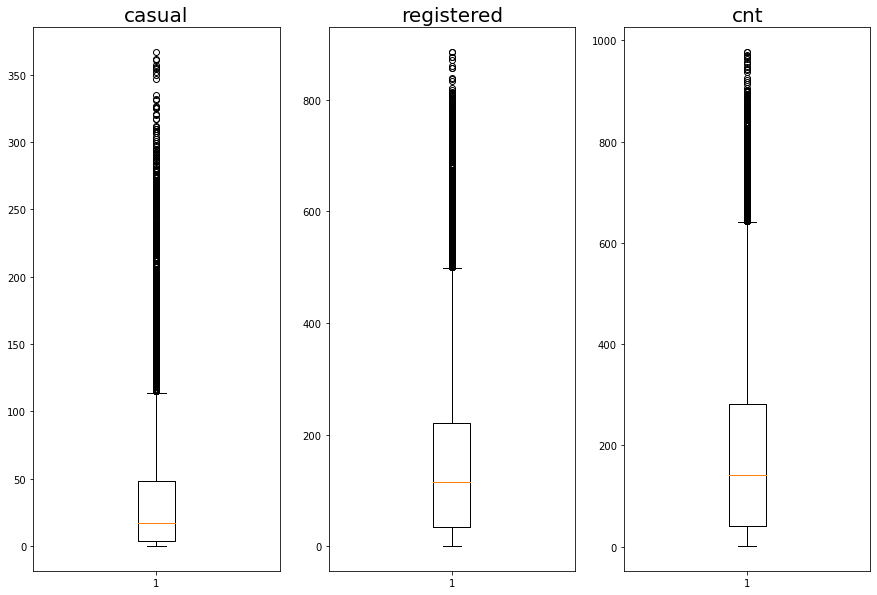

In [103]:
plt.figure(figsize=(15,10))

plt.subplot(1, 3, 1) 
plt.boxplot(bike_df["casual"]) 
plt.title('casual',fontsize=20) 

plt.subplot(1, 3, 2) 
plt.boxplot(bike_df["registered"]) 
plt.title('registered',fontsize=20) 

plt.subplot(1, 3, 3) 
plt.boxplot(bike_df["cnt"]) 
plt.title('cnt',fontsize=20)

plt.show()

The hourly data somehow gives us more outliers.

#### Pairwise relationship between continuous variables

In [104]:
bike_df.corr().style.background_gradient()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,1.000000,0.404046,0.866014,0.489164,-0.004775,0.014723,0.001357,-0.003416,-0.014198,0.136178,0.137615,0.009577,-0.074505,0.158295,0.282046,0.278379
season,0.404046,1.000000,-0.010742,0.830386,-0.006117,-0.009585,-0.002335,0.013743,-0.014524,0.312025,0.319380,0.150625,-0.149773,0.120206,0.174226,0.178056
yr,0.866014,-0.010742,1.000000,-0.010473,-0.003867,0.006692,-0.004485,-0.002196,-0.019157,0.040913,0.039222,-0.083546,-0.008740,0.142779,0.253684,0.250495
mnth,0.489164,0.830386,-0.010473,1.000000,-0.005772,0.018430,0.010400,-0.003477,0.005400,0.201691,0.208096,0.164411,-0.135386,0.068457,0.122273,0.120638
hr,-0.004775,-0.006117,-0.003867,-0.005772,1.000000,0.000479,-0.003498,0.002285,-0.020203,0.137603,0.133750,-0.276498,0.137252,0.301202,0.374141,0.394071
holiday,0.014723,-0.009585,0.006692,0.018430,0.000479,1.000000,-0.102088,-0.252471,-0.017036,-0.027340,-0.030973,-0.010588,0.003988,0.031564,-0.047345,-0.030927
weekday,0.001357,-0.002335,-0.004485,0.010400,-0.003498,-0.102088,1.000000,0.035955,0.003311,-0.001795,-0.008821,-0.037158,0.011502,0.032721,0.021578,0.026900
workingday,-0.003416,0.013743,-0.002196,-0.003477,0.002285,-0.252471,0.035955,1.000000,0.044672,0.055390,0.054667,0.015688,-0.011830,-0.300942,0.134326,0.030284
weathersit,-0.014198,-0.014524,-0.019157,0.005400,-0.020203,-0.017036,0.003311,0.044672,1.000000,-0.102640,-0.105563,0.418130,0.026226,-0.152628,-0.120966,-0.142426
temp,0.136178,0.312025,0.040913,0.201691,0.137603,-0.027340,-0.001795,0.055390,-0.102640,1.000000,0.987672,-0.069881,-0.023125,0.459616,0.335361,0.404772


## 2.4 Prediction on "Casual" User

### 2.4.1 Select all possible features & standardize data if necessary

- **Comment for possible predictors choosing:**
Bellow we choose 'season','mnth','holiday','weekday','workingday','weathersit', 'temp','atemp','hum', and'windspeed' for prediction on numbers of casual users.
To predict the numbers for casual users, we pick two types of factors that are likely to impact their probability to use the services.
The 1st kind of factors are weather related variables. These include season, mnth, weathersit, temp, atemp, hum and windspeed. We assume that a casual user is more willing to use sharing bike when the season/month is warmer, the weather condition is fine, both temperature and feeling temperature are not too cold and too warm, the air is not too humid or too dry, and windspeed are not strong.
The 2nd kind of factors are time related variables. These include holiday, weekday, and workingday. Again, we assume that a casual user is more likely to use sharing bike when it's on holidays/weekends or/and when it's not a workingday.

In [105]:
predictors = ['season','mnth','holiday','weekday','workingday','weathersit', 'temp','atemp','hum','windspeed']
outcome = 'casual'

In [106]:
X = bike_df[predictors]
y = bike_df[outcome]

- Since we are going to use Linear Regression for our prediction, it does not affect our estimation coefficients at all even if we don't standardize our data.

### 2.4.2 Linear Regression with <i>all features
First, we are going to do regression using all of our possible features and see how our model performs:

In [107]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=9)

#### (1) Train our model:

In [108]:
bike_lm = LinearRegression()
bike_lm.fit(X_train, y_train)

LinearRegression()

In [109]:
print('intercept ', bike_lm.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': bike_lm.coef_}))

intercept  41.64337053380536
    Predictor  coefficient
0      season     1.483909
1        mnth     0.069203
2     holiday   -15.002953
3     weekday     0.790289
4  workingday   -36.497422
5  weathersit     3.968158
6        temp    42.641577
7       atemp    80.502784
8         hum   -85.443202
9   windspeed     7.201059


#### (2) Performance on training data:
The result below will show how well the data fits our model.

In [110]:
# print training set performance
regressionSummary(y_train, bike_lm.predict(X_train))


Regression statistics

               Mean Error (ME) : 0.0000
Root Mean Squared Error (RMSE) : 37.6365
     Mean Absolute Error (MAE) : 25.4475


#### (3) Performance on testing data:

In [111]:
# Use predict() to make predictions on a new set
bike_lm_pred = bike_lm.predict(X_test)

In [112]:
result = pd.DataFrame({'Predicted': bike_lm_pred, 'Actual': y_test,
                       'Residual': y_test - bike_lm_pred})
result.head(10)

,Predicted,Actual,Residual
4541,54.702634,0,-54.702634
6457,54.385376,41,-13.385376
8653,6.621484,4,-2.621484
6104,19.818488,32,12.181512
12203,87.623567,223,135.376433
8518,41.197395,28,-13.197395
10376,16.556371,64,47.443629
16526,-5.526089,9,14.526089
2421,26.866859,41,14.133141
13516,73.711793,79,5.288207


In [113]:
# Compute common accuracy measures
regressionSummary(y_test, bike_lm_pred)


Regression statistics

               Mean Error (ME) : -0.2053
Root Mean Squared Error (RMSE) : 37.3736
     Mean Absolute Error (MAE) : 25.4151


#### (4) Check residuals:

Percentage 1.0


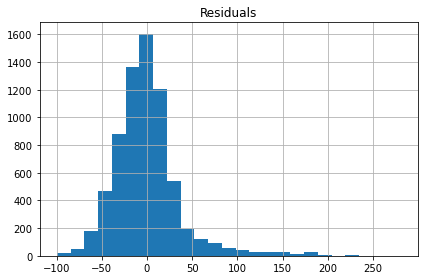

In [114]:
bike_lm_pred = bike_lm.predict(X_test)
all_residuals = y_test - bike_lm_pred

# Determine the percentage of datapoints with a residual in [-1406, 1406] = approx. 75\%
print('Percentage', len(all_residuals[(all_residuals > -1406) & (all_residuals < 1406)]) / len(all_residuals))
# print(all_residuals[(all_residuals > 25000)])

ax = pd.DataFrame({'Residuals': all_residuals}).hist(bins=25)
plt.tight_layout()
plt.show()

We can see from the plot that the residuals are skewed to the right.

### 2.4.3 Feature selection

From the above test results, we could consider a feature selection process in order to keep the best set of regressors.

#### (1) Backward elimination

In [115]:
def train_model(variables):
    model = LinearRegression()
    model.fit(X_train[variables], y_train)
    return model

def score_model(model, variables):
    return AIC_score(y_train, model.predict(X_train[variables]), model)

best_model, best_variables = backward_elimination(X_train.columns, train_model, score_model, verbose=True)
print(best_variables)

Variables: season, mnth, holiday, weekday, workingday, weathersit, temp, atemp, hum, windspeed
Start: score=105272.30
Step: score=105270.43, remove mnth
Step: score=105270.43, remove None
['season', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']


#### (2) Forward selection

In [116]:
# The initial model is the constant model - this requires special handling in train_model and score_model
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(X_train[variables], y_train)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(y_train, [y_train.mean()] * len(y_train), model, df=1)
    return AIC_score(y_train, model.predict(X_train[variables]), model)

best_model, best_variables = forward_selection(X_train.columns, train_model, score_model, verbose=True)
print(best_variables)

Variables: season, mnth, holiday, weekday, workingday, weathersit, temp, atemp, hum, windspeed
Start: score=110901.03, constant
Step: score=108498.38, add temp
Step: score=106949.81, add workingday
Step: score=105414.72, add hum
Step: score=105366.80, add holiday
Step: score=105334.35, add weathersit
Step: score=105307.63, add atemp
Step: score=105289.31, add season
Step: score=105273.15, add weekday
Step: score=105270.43, add windspeed
Step: score=105270.43, add None
['temp', 'workingday', 'hum', 'holiday', 'weathersit', 'atemp', 'season', 'weekday', 'windspeed']


### <i>2.4.4 Prediction formula on casual user count
After using forward selection and backward elimination, we decide that 'temp', 'workingday', 'weathersit', 'windspeed', 'hum', 'weekday', 'holiday', and 'season' are the best predictors for prediction on casual user count.

In [117]:
predictors_casual = ['temp', 'workingday', 'weathersit', 'windspeed', 'hum', 'weekday', 'holiday', 'season', 'atemp']
outcome = 'casual'

X = bike_df[predictors_casual]
y = bike_df[outcome]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=9)

In [118]:
bike_lm_casual = LinearRegression()
bike_lm_casual.fit(X_train, y_train)

LinearRegression()

In [119]:
# print coefficients
print('intercept ', bike_lm_casual.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': bike_lm_casual.coef_}))

intercept  41.6471913667031
    Predictor  coefficient
0        temp    42.608031
1  workingday   -36.500150
2  weathersit     3.966318
3   windspeed     7.205995
4         hum   -85.395150
5     weekday     0.792054
6     holiday   -14.966022
7      season     1.664915
8       atemp    80.460086


In [120]:
print('prediction formula on casual user count: ')
print('')
print('casual user count =', round(bike_lm_casual.intercept_,4), '+', round(bike_lm_casual.coef_[0], 4), '*', str(X.columns[0]), '+(', round(bike_lm_casual.coef_[1], 4),'*',str(X.columns[1]),')\n+(',
      round(bike_lm_casual.coef_[2], 4), '*',str(X.columns[2]),')+(',round(bike_lm_casual.coef_[3], 4),'*',str(X.columns[3]),')+(', round(bike_lm_casual.coef_[4], 4),'*',str(X.columns[4]),')\n+(', round(bike_lm_casual.coef_[5], 4),
      '*',str(X.columns[5]),')+(', round(bike_lm_casual.coef_[6], 4),'*',str(X.columns[6]),')+(', round(bike_lm_casual.coef_[7], 4),'*', str(X.columns[7]), ')+(', round(bike_lm_casual.coef_[8], 4),'*', str(X.columns[8]), ')')

prediction formula on casual user count: 

casual user count = 41.6472 + 42.608 * temp +( -36.5002 * workingday )
+( 3.9663 * weathersit )+( 7.206 * windspeed )+( -85.3952 * hum )
+( 0.7921 * weekday )+( -14.966 * holiday )+( 1.6649 * atemp )+( 80.4601 * atemp )


#### Performance on testing data:

In [121]:
# Use predict() to make predictions on a new set
bike_lm_pred = bike_lm_casual.predict(X_test)

In [122]:
regressionSummary(y_test, bike_lm_pred)


Regression statistics

               Mean Error (ME) : -0.2058
Root Mean Squared Error (RMSE) : 37.3747
     Mean Absolute Error (MAE) : 25.4197


This test performance using our chosen regressors is similar to the one using all predictors. But still note that, our feature selection is using the AIC metric.

## 2.5 Prediction on "Registered" User

### 2.5.1 Select all possible features & standardize data if necessary

**Comment for possible predictors choosing:** 
- Below we choose 'yr','workingday','temp','atemp' for prediction on numbers of registered users. 
- Choosing 'yr' is because we see some correlation between 'registerd' and 'yr'.
- Choosing 'workingday' is because we assume that during workingdays, registered users will more likely to use the bike as transpotation.
- Choosing 'temp' and 'atemp' is because we think temperature matthers to the numbers of registered users.

In [123]:
predictors = ['yr','workingday','temp','atemp']
outcome = 'registered'

In [124]:
X = bike_df[predictors]
y = bike_df[outcome]

### 2.5.2 Linear Regression with <i>all features
First, we are going to do regression using all of our possible features and see how our model performs:

In [125]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=9)

#### (1) Train our model:

In [126]:
bike_lm = LinearRegression()
bike_lm.fit(X_train, y_train)

LinearRegression()

In [127]:
print('intercept ', bike_lm.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': bike_lm.coef_}))

intercept  -38.4985682771933
    Predictor  coefficient
0          yr    77.094756
1  workingday    39.643956
2        temp   233.515919
3       atemp    25.297028


#### (2) Performance on training data:
The result below will show how well the data fits our model.

In [128]:
# print training set performance
regressionSummary(y_train, bike_lm.predict(X_train))


Regression statistics

               Mean Error (ME) : 0.0000
Root Mean Squared Error (RMSE) : 138.4069
     Mean Absolute Error (MAE) : 102.1414


#### (3) Performance on testing data:

In [129]:
# Use predict() to make predictions on a new set
bike_lm_pred = bike_lm.predict(X_test)

In [130]:
result = pd.DataFrame({'Predicted': bike_lm_pred, 'Actual': y_test,
                       'Residual': y_test - bike_lm_pred})
result.head(10)

,Predicted,Actual,Residual
4541,191.194681,4,-187.194681
6457,70.309117,154,83.690883
8653,106.208826,10,-96.208826
6104,125.115042,135,9.884958
12203,250.010770,278,27.989230
8518,53.998662,69,15.001338
10376,217.371769,155,-62.371769
16526,141.566979,629,487.433021
2421,70.309117,168,97.690883
13516,208.431208,179,-29.431208


In [131]:
# Compute common accuracy measures
regressionSummary(y_test, bike_lm_pred)


Regression statistics

               Mean Error (ME) : -4.0378
Root Mean Squared Error (RMSE) : 134.2532
     Mean Absolute Error (MAE) : 100.0064


#### (4) Check residuals:

Percentage 1.0


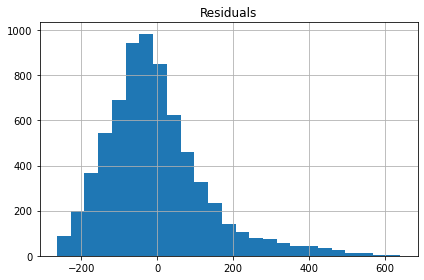

In [132]:
bike_lm_pred = bike_lm.predict(X_test)
all_residuals = y_test - bike_lm_pred

# Determine the percentage of datapoints with a residual in [-1406, 1406] = approx. 75\%
print('Percentage', len(all_residuals[(all_residuals > -1406) & (all_residuals < 1406)]) / len(all_residuals))
# print(all_residuals[(all_residuals > 25000)])

ax = pd.DataFrame({'Residuals': all_residuals}).hist(bins=25)
plt.tight_layout()
plt.show()

We can see from the plot that the residuals are skewed a little bit to the right.

### 2.5.3 Feature selection

From the above test results, we could consider a feature selection process in order to keep the best set of regressors.

#### (1) Backward elimination

In [133]:
def train_model(variables):
    model = LinearRegression()
    model.fit(X_train[variables], y_train)
    return model

def score_model(model, variables):
    return AIC_score(y_train, model.predict(X_train[variables]), model)

best_model, best_variables = backward_elimination(X_train.columns, train_model, score_model, verbose=True)
print(best_variables)

Variables: yr, workingday, temp, atemp
Start: score=132416.89
Step: score=132415.14, remove atemp
Step: score=132415.14, remove None
['yr', 'workingday', 'temp']


#### (2) Forward selection

In [134]:
# The initial model is the constant model - this requires special handling in train_model and score_model
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(X_train[variables], y_train)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(y_train, [y_train.mean()] * len(y_train), model, df=1)
    return AIC_score(y_train, model.predict(X_train[variables]), model)

best_model, best_variables = forward_selection(X_train.columns, train_model, score_model, verbose=True)
print(best_variables)

Variables: yr, workingday, temp, atemp
Start: score=134597.88, constant
Step: score=133346.35, add temp
Step: score=132596.06, add yr
Step: score=132415.14, add workingday
Step: score=132415.14, add None
['temp', 'yr', 'workingday']


### 2.5.4 Prediction formula on registered user count
After using forward selection and backward elimination, we decide that 'temp', 'workingday', 'weathersit', 'windspeed', 'hum', 'weekday', 'holiday', and 'season' are the best predictors for prediction on casual user count.

In [135]:
predictors_regist = ['yr', 'temp', 'workingday']
outcome = 'registered'

X = bike_df[predictors_regist]
y = bike_df[outcome]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=9)

In [136]:
bike_lm_regist = LinearRegression()
bike_lm_regist.fit(X_train, y_train)

LinearRegression()

In [137]:
# print coefficients
print('intercept ', bike_lm_regist.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': bike_lm_regist.coef_}))

intercept  -37.540558851433246
    Predictor  coefficient
0          yr    77.085528
1        temp   255.829195
2  workingday    39.632436


In [138]:
print('prediction formula on registered user count')
print('')
print('registered user count =', round(bike_lm_regist.intercept_, 4), '+(', round(bike_lm_regist.coef_[0], 4),'*',str(X.columns[0]),')+(', round(bike_lm_regist.coef_[1], 4),'*',str(X.columns[1]),')+(', round(bike_lm_regist.coef_[2], 4),'*',str(X.columns[2]),')')

prediction formula on registered user count

registered user count = -37.5406 +( 77.0855 * yr )+( 255.8292 * temp )+( 39.6324 * workingday )


#### Performance on testing data:

In [139]:
# Use predict() to make predictions on a new set
bike_lm_pred = bike_lm_regist.predict(X_test)

In [140]:
regressionSummary(y_test, bike_lm_pred)


Regression statistics

               Mean Error (ME) : -4.0358
Root Mean Squared Error (RMSE) : 134.2662
     Mean Absolute Error (MAE) : 100.0095


## 2.6 Prediction on total count in year 2013

In [141]:
# we choose mean values on 2011 and 2012 to predict daily data in 2013
mean_casual = bike_df[predictors_casual].mean().values.reshape(1, 9)
casual_user_count = bike_lm_casual.predict(mean_casual)

In [142]:
mean_regist = bike_df[predictors_regist].mean().values.reshape(1, 3)

In [143]:
# we use yr=2 for 2013
mean_regist[0, 0] = 2 

In [144]:
registered_user_count = bike_lm_regist.predict(mean_regist)

In [145]:
# summing up casual and registered user count
total_user_count = casual_user_count + registered_user_count

In [146]:
# print out each prediction
print('2013 Daily casual user count:',casual_user_count[0].round())
print('2013 Daily registered user count:', registered_user_count[0].round())
print('2013 Daily total user count:', total_user_count[0].round())

2013 Daily casual user count: 36.0
2013 Daily registered user count: 271.0
2013 Daily total user count: 307.0


### 2.6.1 Comparison of daily total user count in 2011, 2012 and 2013

In [147]:
print('2011 daily total user count:',round(np.mean(bike_df[bike_df["yr"] == 0]['cnt']),0))
print('2012 daily total user count:',round(np.mean(bike_df[bike_df["yr"] == 1]['cnt']),0))
print('2013 daily total user count:', total_user_count.round()[0])

2011 daily total user count: 144.0
2012 daily total user count: 235.0
2013 daily total user count: 307.0


### 2.6.2 Comparison of daily casual user count in 2011, 2012 and 2013

In [148]:
print('2011 daily casual user count:',round(np.mean(bike_df[bike_df["yr"] == 0]['casual']),0))
print('2012 daily casual user count:',round(np.mean(bike_df[bike_df["yr"] == 1]['casual']),0))
print('2013 daily casual user count:', casual_user_count.round()[0])

2011 daily casual user count: 29.0
2012 daily casual user count: 43.0
2013 daily casual user count: 36.0


### 2.6.3 Comparison of daily registered user count in 2011, 2012 and 2013

In [149]:
print('2011 daily registered user count:',round(np.mean(bike_df[bike_df["yr"] == 0]['registered']),0))
print('2012 daily registered user count:',round(np.mean(bike_df[bike_df["yr"] == 1]['registered']),0))
print('2013 daily registered user count:', registered_user_count.round()[0])

2011 daily registered user count: 115.0
2012 daily registered user count: 192.0
2013 daily registered user count: 271.0


## 2.7 Prediction Results Interpretation

Similar to our daily data, we predict both casual and registered users in 2013, and calculation the hourly total user count by summing up casual and registered user count. The hourly total user count is about 307.0, which is higher than 144.0 counts in year 2011 and 235.0 counts in year 2012. Also, combined with the fact that the users were increasing from 2011 to 2012, we suggest that the bike sharing company should purchase more bike to fit the increasing demand.

In section 3.2, we see a decrease on hourly casual user count on 2013 based on our prediction. And in section 3.3, see a increase on hourly registered user count on 2013. The reason for these might be explained by several reasons: 

1. Some casual user become registered user. Thus, some portion of the increase of hourly registered user count may come from the casual user. This might be a good sign for the company. 

2. If the increase of registered users were not highly related to the decrease of casual users, then it might indicate that sharing bike has a increasing value on working transpotaion, instead of recreation purposes. Based on these, we suggust company could spend more funding on advertisement targeting working group, thus attracting more potantial customers.

## 2.8 Conclusion and Reflection

1. Domain-specific reasoning: It's a good sign to see increase in registered users from 2011 to 2013. However, to really understand the increase, we will need to analyze extra data on the registered users.
2. Modeling process-specific reasoning: In this project, we use linear regression instead of using nonlinear model. Maybe a nonlinear model will fit better on the dataset.